# Perturbation for general consumer resource model 

In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, BoundaryNorm
#import seaborn as sns 
import cvxpy as cvx
import copy
from iterative_perturbation import general_perturbation_prediction
from iterative_perturbation import prediction_given_Sbool

We are considering general consumer resource model 

\begin{align}
\frac{dN_i}{dt}&=N_i(\sum_\alpha C_{i\alpha}R_\alpha-m_i)\\
\frac{dR_\alpha}{dt}&=R_\alpha(K_\alpha - \sum_\beta Q_{\alpha \beta} R_\beta-\sum_j E_{j\alpha}N_j) .
\label{eq: general MCRM}
\end{align}

and test if the our correctly predict the species abundance after perturbations. To find the steady state, we could numerically solve the ODE , but we can also solve the equivalent constrained optimization problem.
\begin{align}
    \min_{\vec{R}} \sum_{\alpha\beta}\frac{1}{2}R_\alpha Q_{\alpha \beta} R_\beta-\sum_{\alpha}K_\alpha R_{\alpha}
\end{align}
with constraints
\begin{align}
    \sum_\alpha C_{i\alpha}R_\alpha-m_i&\leq0\\
    R_\alpha&>0
\end{align}


max integration time reached


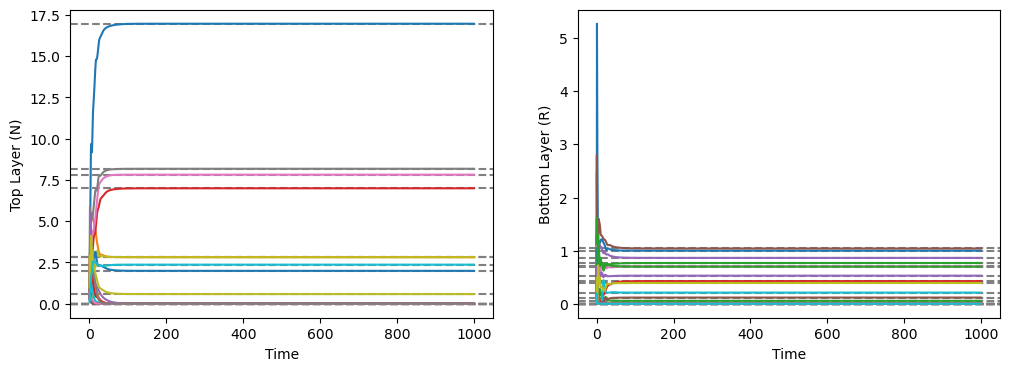

In [2]:
def generate_model_params(top_species, resources, C_mean, C_std_dev, rho, Q_mean, Q_std_dev, Q_rho, u_mean, u_std_dev, k_mean, k_std_dev):
    zero_mean_c = C_std_dev * np.random.normal(0, 1, (top_species, resources)) / np.sqrt(resources)
    C = C_mean/resources + zero_mean_c
    u = np.random.normal(u_mean, u_std_dev,top_species)
    E = generate_E(C_mean, top_species, resources, rho, zero_mean_c)
    q = np.random.normal(Q_mean,Q_std_dev, (resources, resources))
    q_a = np.random.normal(Q_mean,Q_std_dev,( resources, resources))
    Q = np.eye(resources)+Q_rho*(np.tril(q) + np.tril(q, -1).T)+ np.sqrt(1 - Q_rho) * (np.tril(q_a) -  np.tril(q_a, -1).T)  #symmetric  + antisymmetric part of Q
    k = np.random.normal(k_mean, k_std_dev,resources)
    return C, u, E, k, Q

def generate_E(E_mean, top_species, resources, rho, zero_mean_c ):
    zero_mean_d = C_std_dev * np.random.normal(0, 1, (top_species, resources)) / np.sqrt(resources)
    return E_mean/resources + rho * zero_mean_c   + np.sqrt(1 - rho**2) * zero_mean_d

def consumer_resource(t, state, top_species, C, u, k, Q,migration):
    
    X = state[:top_species]
    R = state[top_species:]

    dX = X * (np.dot(C, R) - u)+migration
    dR = R * (k - Q@R - np.dot(C.T, X))+migration

    return np.concatenate((dX, dR), axis=None)

def linear_consumer_resource(t, state, top_species, C, u, k, Q):
    
    X = state[:top_species]
    R = state[top_species:]

    dX =  (np.dot(C, R) - u)
    dR =  (k - Q@R - np.dot(C.T, X))

    return np.concatenate((dX, dR), axis=None)

def ODE_simulator(initial_state, top_species, resources, C, E, u, k, Q, migration, max_time=50000, steady_state_threshold=1e-12):
   
    ode_function = lambda t, state: consumer_resource(t, state, top_species, C, u, k, Q, migration)
    
    def check_steady_state(t, y): #Since the aim in this notebook is to find steady states, we make a event 
        derivatives = ode_function(t, y)
        #print(np.max(np.abs(derivatives)) < steady_state_threshold)
    
        return np.max(np.abs(derivatives)/y) > steady_state_threshold

    # Integrate until steady state or max_time is reached
    check_steady_state.terminal = True
    sol = solve_ivp(ode_function, t_span=(0, max_time), y0=initial_state.copy(), method='LSODA', atol=1e-10, rtol=1e-10, events=[check_steady_state])
    
    # Check if the integration reached the maximum time
    time_limit_reached = sol.t[-1] == max_time
    if time_limit_reached: print('max integration time reached')

    
    # Take surviving species
    simulator_Sbool=[(np.log(x) > np.log(migration)/2) for x in sol.y.T[-1]]
    N_simulator_Sbool=simulator_Sbool[:top_species]
    R_simulator_Sbool=simulator_Sbool[top_species:]
    #simulate again with extinct species removed, with linear dynamics, and previous steady state as initial state
    linear_ode_function = lambda t, state: linear_consumer_resource(t, state, sum(N_simulator_Sbool), C[N_simulator_Sbool,::][::,R_simulator_Sbool], u[N_simulator_Sbool], k[R_simulator_Sbool], Q[R_simulator_Sbool,::][::,R_simulator_Sbool]) #lambda t, state: linear_lotka_volterra(t, state, A[simulator_Sbool,::][::,simulator_Sbool], u[simulator_Sbool])
    
    def linear_check_steady_state(t, y): #Since the aim in this notebook is to find steady states, we make a event 
        derivatives = linear_ode_function(t, y)
        return np.max(np.abs(derivatives)) > steady_state_threshold
    linear_check_steady_state.terminal = True
    linear_sol = solve_ivp(linear_ode_function, t_span=(0, max_time), y0=sol.y.T[-1][simulator_Sbool], method='LSODA', atol=1e-12, rtol=1e-12, events=[linear_check_steady_state])
    
    #extinct species abundance are set to 0 
    full_sol=np.zeros(top_species+resources)
    full_sol[simulator_Sbool]=linear_sol.y.T[-1]
    return full_sol, linear_sol, sol

def decompose_matrix(Q):
    # Ensure A is a numpy array
    Q = np.array(Q)
    
    # Calculate the symmetric part
    Q_S = 0.5 * (Q + Q.T)
    
    # Calculate the anti-symmetric part
    Q_A = 0.5 * (Q - Q.T)
    
    return Q_S, Q_A

def find_steady_state(k, C, E, Q, u, max_iteration=100000, alpha=0.9, tol=1e-8):
    keff = k.copy()
    Q_S, Q_A = decompose_matrix(Q)
    Delta = 1
    iteration = 0
    ncyc= 0 #number of cycles
    Delta_old = 0
    
    resources=len(k)
        
    while Delta > tol and iteration < max_iteration:
        #try:
        R_opt = cvx.Variable(resources)
        constraints = [C @ R_opt <= u, R_opt >= 0]
        prob = cvx.Problem(cvx.Minimize((1/2)*cvx.quad_form(R_opt, Q_S) - keff.T @ R_opt), constraints)
        prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-8, eps_rel=1e-8, max_iter=100000, verbose=False,polish=True)

        N_values = prob.constraints[0].dual_value
        R_values = R_opt.value
        deltak = k + (C.T - E.T) @ N_values - Q_A@ R_values - keff
        keff += alpha * deltak

        Delta_next = abs(np.max(k - Q@R_values - E.T @ N_values))

        if np.isfinite(Delta) and Delta > tol and np.abs(Delta-Delta_old) < 0.1*tol: 
                ncyc+=1 #check if the different

        Delta_old = Delta
        Delta = Delta_next
        iteration += 1
       # except:
       #     keff=keff+np.random.uniform(-1,1)*len(keff)
       #     print('optimizatino error')
                    
                    
 
        #if ncyc > 10:
        #    print('Limit cycle detected')
        #    keff=keff+np.random.uniform(-1,1)*len(keff)
        #    ncyc = 0

    if iteration == max_iteration:
        print('Delta = ',Delta,'Maximum iterations exceeded. Optimization failed. Returned inaccurate result')
        return N_values, R_values
    else:
        return N_values, R_values
    
    
def plot_simulation_results(N_values, R_values, sol, top_species, resources, yscale='linear', xscale='linear', plot_optimization=True):
    plt.figure(figsize=(12, 4))

    # Plotting top layer (N)
    plt.subplot(1, 2, 1)
    if plot_optimization:
        for value in N_values:
            plt.axhline(value, color='grey', ls='--')
    plt.plot(sol.t, sol.y[:top_species].T)
    plt.xlabel('Time')
    plt.ylabel('Top Layer (N)')
    plt.yscale(yscale)
    plt.xscale(xscale)

    # Plotting bottom layer (R)
    plt.subplot(1, 2, 2)
    if plot_optimization:
        for value in R_values:
            plt.axhline(value, color='grey', ls='--')
    plt.plot(sol.t, sol.y[top_species:].T)
    plt.xlabel('Time')
    plt.ylabel('Bottom Layer (R)')
    plt.yscale(yscale)
    plt.xscale(xscale)

    plt.show()
    
    
#Example usage
top_species = 20
resources = 30
C_mean = 5
C_std_dev = 1
rho = 1
migration = 1e-9
Q_mean = 0.5
Q_std_dev = 0.1
Q_rho = 0.5
u_mean, u_std_dev, k_mean, k_std_dev = 1,0.1,10,0.1

# Generate model parameters
C, u, E, k, Q = generate_model_params(top_species, resources, C_mean, C_std_dev, rho, Q_mean, Q_std_dev, Q_rho, u_mean, u_std_dev, k_mean, k_std_dev)

# Define simulation parameters
max_time=1000
initial_state = np.random.rand(top_species + resources)

N_values, R_values=find_steady_state(k, C, E, Q, u, max_iteration=1000, alpha=0.9, tol=1e-5)
#Run simulation
_,linear_result,result = ODE_simulator( initial_state, top_species, resources, C, E, u, k,Q, migration,max_time)
plot_simulation_results(N_values, R_values, result, top_species, resources, plot_optimization=True, yscale='linear')





In [3]:
def create_block_matrix(A, B, C, D):   

    # Create the block matrix using np.block
    block_matrix = np.block([
        [A, B],
        [C, D]
    ])
    
    return block_matrix

def make_A(C,E,Q):
    zeros=np.zeros((len(C),len(C)))
    # Create the block matrix using create_block_matrix
    A = create_block_matrix(zeros, C,E.T, Q)
    return A

def make_X(N,R):
    X=np.concatenate((N,R))
    return X

def make_u(m,k):
    u=np.concatenate((-m,k))
    return u

def set_random_true(boolean_array, num_to_set_true): # for knockoffs
    # Get indices of False values in the array
    false_indices = np.where(boolean_array == False)[0]
    
    # If there are fewer False values than num_to_set_true, raise an error
    if len(false_indices) < num_to_set_true:
        raise ValueError("Number of False values is less than num_to_set_true.")
        
    # Randomly choose indices to set to True
    indices_to_set_true = np.random.choice(false_indices, num_to_set_true, replace=False)
    
    # Set the chosen indices to True
    boolean_array[indices_to_set_true] = True
    
    return boolean_array
def predict_CRM_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I, delta_m,knock_off, num_iters=50, momentum=0.1,N_survival_threshold=1e-5,R_survival_threshold=1e-5):
    num_resources=len(k)
    num_invaders=len(m_I)
    num_native=len(Cs)
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(-ms,k)
    delta_u=make_u(delta_m,np.zeros(len(Qs)))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),-C_I]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    u_I=-m_I
    full_knock_off=np.concatenate((knock_off,np.array([False]*len(Qs))))
    survival_threshold=np.concatenate((np.full(num_native+num_invaders,N_survival_threshold),np.full(num_resources,R_survival_threshold)))
    predicted_XList=general_perturbation_prediction(As,oldXs,us,delta_u,full_knock_off,A_II,A_IS,A_SI, u_I, num_iters, momentum,survival_threshold)
    perturbation_prediction = np.array(predicted_XList)[-1]   
    native_N_prediction=perturbation_prediction[:num_native]
    native_R_prediction=perturbation_prediction[num_native:num_native+len(Qs)]
    invader_N_prediction=perturbation_prediction[num_native+len(Qs):]

    return np.concatenate((native_N_prediction,invader_N_prediction)), native_R_prediction

def info_predict_CRM_with_LV(Cs,Es,Qs,oldNs,oldRs,ms,k,E_I, C_I, m_I,delta_m,knock_off,N_simulator_Sbool,R_simulator_Sbool):
    resources=len(k)
    num_invaders=len(m_I)
    num_native=len(Cs)
    
    As=make_A(Cs,Es,Qs)
    oldXs=make_X(oldNs,oldRs)
    us=make_u(-ms,k)
    delta_u=make_u(-delta_m,np.zeros(resources))
    A_II=np.zeros((num_invaders,num_invaders))
    A_IS=np.block([[np.zeros((num_invaders,num_native)),-C_I]])
    A_SI=np.block([[np.zeros((num_native,num_invaders))],[E_I.T]])
    u_I=-m_I
    Sbool_I=N_simulator_Sbool[len(Cs):]
    Sbool=np.concatenate((N_simulator_Sbool[:len(Cs)],R_simulator_Sbool))
    perturbation_prediction,screened_invader_impact,M_inv, invasion_fitness=prediction_given_Sbool(As,oldXs,us,delta_u,A_II,A_IS,A_SI, u_I,Sbool,Sbool_I)
    
    screened_invader_impact_N=screened_invader_impact[:-sum(R_simulator_Sbool)]
    screened_invader_impact_R=screened_invader_impact[-sum(R_simulator_Sbool):]
    
    native_N_prediction=perturbation_prediction[:num_native]
    native_R_prediction=perturbation_prediction[num_native:num_native+resources]
    invader_N_prediction=perturbation_prediction[num_native+resources:]
    
    return np.concatenate((native_N_prediction,invader_N_prediction)),native_R_prediction, screened_invader_impact_N,screened_invader_impact_R, M_inv, invasion_fitness

def consumer_invasion_and_knock_off(C, E, Q, C_I, E_I, m, m_I, knock_off):
    not_knock_off= np.logical_not(knock_off)
    C_new=np.concatenate((C[not_knock_off],C_I))
    E_new=np.concatenate((E[not_knock_off],E_I))
    m_new = np.concatenate((m[not_knock_off], m_I))
    return C_new, E_new, m_new


In [4]:
def deduce_extinction_threshold_log(data):
    """
    Deduce a threshold for extinction in abundance data using the log distribution and the middle of the gap.
    
    Parameters:
    data (array-like): Array of abundance data.
    
    Returns:
    float: The deduced extinction threshold.
    """
    data = np.array(data)
    data_nonzero = data[data > 0]  # Remove zero or negative values to avoid log issues
    log_data = np.log(data_nonzero)
    
    # Sort the log-transformed data
    sorted_log_data = np.sort(log_data)
    
    # Find the middle of the largest gap in the log-transformed data
    log_gaps = np.diff(sorted_log_data)
    max_gap_index = np.argmax(log_gaps)
    
    middle_of_gap = (sorted_log_data[max_gap_index] + sorted_log_data[max_gap_index + 1]) / 2
    
    # Convert back from log scale to original scale
    threshold = np.exp(middle_of_gap)
    
    return threshold


In [5]:
from multiprocess import Pool

assumptions = {
    "num_knock_offs": 0,
    "num_invaders": 1,
    "top_species": 60,
    "resources": 30,
    "C_mean": 1,
    "C_std_dev": 0.5,
    "rho": 1,
    "Q_mean": 0.1,
    "Q_std_dev": 0.1,
    "Q_rho": 0.1,
    "u_mean": 1,
    "u_std_dev": 0.1,
    "k_mean": 2,
    "k_std_dev": 0.1,
    "deltam_mean": 0,
    "deltam_std_dev": 0
}

def simulate_single_system(assumptions):
    np.random.seed(None)
    # Extract parameters from the assumptions dictionary
    top_species = assumptions['top_species']
    resources = assumptions['resources']
    C_mean = assumptions['C_mean']
    C_std_dev = assumptions['C_std_dev']
    rho = assumptions['rho']
    Q_mean = assumptions['Q_mean']
    Q_std_dev = assumptions['Q_std_dev']
    Q_rho = assumptions['Q_rho']
    u_mean = assumptions['u_mean']
    u_std_dev = assumptions['u_std_dev']
    k_mean = assumptions['k_mean']
    k_std_dev = assumptions['k_std_dev']
    num_knock_offs = assumptions['num_knock_offs']
    num_invaders = assumptions['num_invaders']
    deltam_mean = assumptions['deltam_mean']
    deltam_std_dev = assumptions['deltam_std_dev']
    N_threshold = assumptions.get('N_threshold', 1e-3)
    R_threshold = assumptions.get('R_threshold', 1e-9)

    # Generate model parameters for each system
    C, m, E, k, Q = generate_model_params(top_species, resources, C_mean, C_std_dev, rho,
                                          Q_mean, Q_std_dev, Q_rho,
                                          u_mean, u_std_dev, k_mean, k_std_dev)
    
    
    # Simulate the initial system
    oldN, oldR = find_steady_state(k, C, E, Q, m, max_iteration=1000, alpha=0.1, tol=1e-7)
    
    # Determine extinction thresholds
    N_Sbool = [(x > N_threshold) for x in oldN]
    R_Sbool = [(x > R_threshold) for x in oldR]
    #print(oldN,flush=True)
    num_native = sum(N_Sbool)
    num_sur_resources = sum(R_Sbool)

    Cs = C[N_Sbool][:, R_Sbool]
    Es = E[N_Sbool][:, R_Sbool]
    ms = m[N_Sbool]
    oldNs = oldN[N_Sbool]
    oldRs = oldR[R_Sbool]
    ks = k[R_Sbool]
    Qs = Q[R_Sbool][:, R_Sbool]

    # Sample knockoff
    knock_off = np.array([False] * num_native)
    knock_off = set_random_true(knock_off, num_knock_offs)
    not_knock_off = np.concatenate((np.logical_not(knock_off), np.array([True] * num_invaders)))

    # Sample invaders until invasion fitness is positive
    continue_sampling = True
    while continue_sampling:
        C_I, m_I, E_I, _, _ = generate_model_params(num_invaders,
                                                    num_sur_resources,
                                                    C_mean,
                                                    C_std_dev,
                                                    rho,
                                                    Q_mean,
                                                    Q_std_dev,
                                                    Q_rho,
                                                    u_mean,
                                                    u_std_dev,
                                                    k_mean,
                                                    k_std_dev)
        if C_I @ oldRs - m_I > 0:
            continue_sampling = False

    # Sample environmental perturbation
    delta_m = np.random.normal(deltam_mean, deltam_std_dev, num_native)

    # Add invaders and remove knockoffs
    new_top_species = num_native + num_invaders - num_knock_offs
    new_initial_state = np.random.rand(new_top_species + num_sur_resources)

    # Simulate the new system with the perturbation
    C_new, E_new, m_new = consumer_invasion_and_knock_off(Cs,
                                                          Es,
                                                          Qs,
                                                          C_I,
                                                          E_I,
                                                          ms + delta_m,
                                                          m_I,
                                                          knock_off)
    
    newN = np.zeros(new_top_species)
    
    newN[not_knock_off], newR = find_steady_state(ks,
                                                      C_new,
                                                      E_new,
                                                      Qs,
                                                      m_new,
                                                      max_iteration=1000,
                                                      alpha=0.1,
                                                      tol=1e-7)
    
    N_simulator_Sbool = [(x > N_threshold) for x in newN]
    R_simulator_Sbool = [(x > R_threshold) for x in newR]
    
    # Compute perturbation prediction with iterative method
    N_prediction,R_prediction=predict_CRM_with_LV(Cs,
                                                  Es,
                                                  Qs,
                                                  oldNs,
                                                  oldRs,
                                                  ms,
                                                  ks,
                                                  E_I,
                                                  C_I,
                                                  m_I,
                                                  delta_m,
                                                  knock_off,
                                                  num_iters=50,
                                                  momentum=0.1,
                                                  N_survival_threshold=N_threshold,
                                                  R_survival_threshold=R_threshold)
    
    info_Nprediction, info_Rprediction,\
    screened_invader_impact_N,\
    screened_invader_impact_R,\
    Minv,invasion_fitness = info_predict_CRM_with_LV(Cs,
                                    Es,
                                    Qs,
                                    oldNs,
                                    oldRs,
                                    ms,
                                    ks,
                                    E_I,
                                    C_I,
                                    m_I,
                                    delta_m,
                                    knock_off,
                                    N_simulator_Sbool,
                                    R_simulator_Sbool)

    return {"simulationN_after": newN,
            "simulationR_after": newR,
            "simulationN_before": oldNs,
            "simulationR_before": oldRs,
            "predictionNs": N_prediction,
            "predictionRs": R_prediction,
            "invader_ODE_steady_states": newN[-1],
            "invader_predictions": N_prediction[-1],
            "sim_Nbools": N_simulator_Sbool,
            "sim_Rbools": R_simulator_Sbool,
            "prediction_Nbool": N_prediction > N_threshold,
            "prediction_Rbool": R_prediction > R_threshold,
            "screened_invader_impact_N": screened_invader_impact_N,
            "screened_invader_impact_R": screened_invader_impact_R,
            "Minv": Minv,
            "invasion_fitness": invasion_fitness,
            "info_Nprediction": info_Nprediction, 
            "info_Rprediction": info_Rprediction
    }

num_systems = 640

if __name__ == '__main__':
     with Pool() as pool:
         temp_results=[pool.apply_async(simulate_single_system,args=(assumptions,))
                       for _ in range(num_systems)]
         
         output_data=[res.get() for res in temp_results]


def unpack_results(results):
    if not results:
        return {}
    # Extract all keys from the first result
    keys = results[0].keys()
    # Create a dictionary with each key mapped to a list of corresponding values
    return {key: [result[key] for result in results] for key in keys}
MCRM_unpacked_data = unpack_results(output_data)

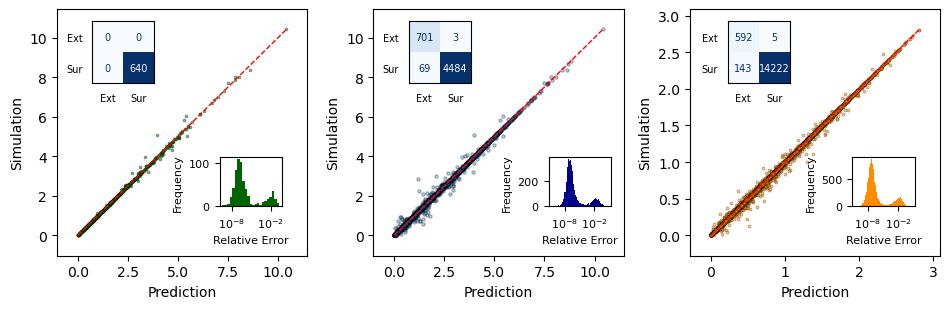

In [12]:
 from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'


def plot_confusion_matrix(true_labels, predicted_labels, labels=('Ext', 'Sur'), font_size=7, ax=None):
    cm = confusion_matrix(true_labels, predicted_labels, labels = [False,True])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    display.plot(cmap='Blues', ax=ax, colorbar=False)
    
    # Set custom tick labels
    ax.set_xticklabels(labels, fontsize=font_size)
    ax.set_yticklabels(labels, fontsize=font_size)
    
    # Remove or customize axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Customize grid appearance
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False)

    # Change font size of text annotations
    for text in display.text_.ravel():
        text.set_fontsize(font_size)

    if ax is None:
        plt.tight_layout()
        plt.show()


# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 3, figsize=(figure_width * 3, figure_width * 1))

# Filter data for positive predictions
sim_Nbools_concatenated = np.concatenate(MCRM_unpacked_data['sim_Nbools'])
prediction_Nbool_concatenated = np.concatenate(MCRM_unpacked_data['prediction_Nbool'])
intersection = [a and b for a, b in zip(sim_Nbools_concatenated, prediction_Nbool_concatenated)]
positive_indices_N = np.array(intersection) > 0

# Filter data for positive predictions
sim_Rbools_concatenated = np.concatenate(MCRM_unpacked_data['sim_Rbools'])
prediction_Rbool_concatenated = np.concatenate(MCRM_unpacked_data['prediction_Rbool'])
intersection = [a and b for a, b in zip(sim_Rbools_concatenated, prediction_Rbool_concatenated)]
positive_indices_R = np.array(intersection) > 0

filtered_simulationR_after = np.concatenate(MCRM_unpacked_data['simulationR_after'])[positive_indices_R]
filtered_predictionRs = np.concatenate(MCRM_unpacked_data['predictionRs'])[positive_indices_R]


filtered_simulationN_after = np.concatenate(MCRM_unpacked_data['simulationN_after'])[positive_indices_N]
filtered_predictionNs = np.concatenate(MCRM_unpacked_data['predictionNs'])[positive_indices_N]

# Calculate R^2 values
#r2_n = r2_score(filtered_simulationN_after, filtered_predictionNs)
#r2_r = r2_score(filtered_simulationR_after, filtered_predictionRs)

# Scatter plot for N (reversed axes)
maxN = np.max(np.concatenate(MCRM_unpacked_data['predictionNs']))
scatter_n = ax[1].scatter(filtered_predictionNs, filtered_simulationN_after, s=5, alpha=0.3, c='dodgerblue', edgecolors='black')
ax[1].plot([0, maxN], [0, maxN], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_ylim(-maxN * 0.1, 1.1 * maxN)
#ax[1].set_title(f'consumer $N_i$')

# Add confusion matrix inset for N
inset_ax_n = ax[1].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Nbools_concatenated, prediction_Nbool_concatenated, ax=inset_ax_n)


# Histogram for relative error of N
ax_hist1 = ax[1].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist1.hist(np.log10(np.abs(filtered_simulationN_after - filtered_predictionNs) / filtered_simulationN_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist1.set_xlabel('Relative Error', fontsize=8)
ax_hist1.set_ylabel('Frequency', fontsize=8)
ax_hist1.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist1.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist1.set_xticks([-8, -2])  # Replace with your desired tick positions
ax_hist1.set_xticklabels(['$10^{-8}$', '$10^{-2}$'])  # Replace with your desired tick labels


# Scatter plot for R 
maxR = np.max(np.concatenate(MCRM_unpacked_data['predictionRs']))
scatter_r = ax[2].scatter(filtered_predictionRs, filtered_simulationR_after, s=5, alpha=0.5, linewidth=0.3, c='darkorange', edgecolors='black')
ax[2].plot([0, maxR], [0, maxR], color='r', linestyle='dashed', linewidth=1)
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Simulation')
ax[2].set_xlim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_ylim(-maxR * 0.1, 1.1 * maxR)
#ax[2].set_title(f'resource $R_α$')

# Add confusion matrix inset for R
inset_ax_r = ax[2].inset_axes([0.15, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_Rbools_concatenated, prediction_Rbool_concatenated, ax=inset_ax_r)

# Histogram for relative error of R
ax_hist2 = ax[2].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulationR_after - filtered_predictionRs) / filtered_simulationR_after), bins='auto', color='darkorange', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
# Set custom x-ticks
ax_hist2.set_xticks([-8, -2])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-8}$', '$10^{-2}$'])  # Replace with your desired tick labels


simulation_invader = np.array([x[-1] for x in MCRM_unpacked_data['simulationN_after']])
prediction_invader = np.array([x[-1] for x in MCRM_unpacked_data['predictionNs']])


sim_invader_bool =  np.array([x[-1] for x in MCRM_unpacked_data['sim_Nbools']])
pred_invader_bool =  np.array([x[-1] for x in MCRM_unpacked_data['prediction_Nbool']])

intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]
N0_positive_indices = np.array(intersection) > 0
#print(sim_invader_bool,pred_invader_bool)

# Filter N_0 data for positive predictions
filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]
#r2_n0 = r2_score(filtered_simulation_invader, filtered_prediction_invader)


# Scatter plot for N_0 
maxN0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.5, linewidth=0.3, c='darkgreen', edgecolors='black')
ax[0].plot([0, maxN0], [0, maxN0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_ylim(-maxN0 * 0.1, 1.1 * maxN0)
#ax[0].set_title(f'invader $N_0$')

# Add confusion matrix inset for N_0
inset_ax_n0 = ax[0].inset_axes([0.14, 0.7, 0.25, 0.25])
plot_confusion_matrix(sim_invader_bool, pred_invader_bool, ax=inset_ax_n0)

# Histogram for relative error of N_0
ax_hist0 = ax[0].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)
ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist0.set_xticks([-8, -2])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-8}$', '$10^{-2}$'])  # Replace with your desired tick labels

plt.tight_layout()
fig.savefig("MCRM_work.svg", format="svg")
fig.savefig("MCRM_work.pdf", format="pdf")

plt.show()

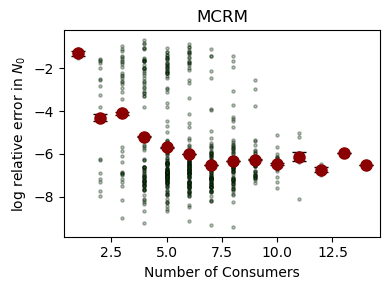

In [13]:

n_consumers=[]
similarity_score=[]
count_yes=0
count_no=0
for sim_bool, pred_bool in zip(MCRM_unpacked_data['sim_Nbools'], MCRM_unpacked_data['prediction_Nbool']):
    # Get intersection of where both sim and pred are True
    intersection = np.logical_and(sim_bool[:-1], pred_bool[:-1])
    # Count number of True values

    if pred_bool[-1]:
        n_consumers.append(np.sum(intersection))
        similarity_score.append(np.sum(intersection)/len(sim_bool))

# Calculate relative error for N_0
relative_error_N0 = np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader


# Create arrays to store mean and percentiles for each unique number of consumers
unique_n_consumers = np.unique(n_consumers)
mean_errors = []
error_bars = []
# percentile_25 = []
# percentile_75 = []

# Calculate statistics for each unique number of consumers
for n in unique_n_consumers:
    mask = np.array(n_consumers) == n
    errors = relative_error_N0[mask]
    
    # Calculate statistics in log scale
    log_errors = np.log10(errors)
    mean_errors.append(np.mean(log_errors))
    error_bars.append(np.std(log_errors)/len(errors))
    # percentile_25.append(np.percentile(log_errors, 25))
    # percentile_75.append(np.percentile(log_errors, 75))


# Create new figure
plt.figure(figsize=(4, 3))

# Plot mean with error bars
plt.errorbar(unique_n_consumers, mean_errors, yerr=error_bars, 
             fmt='o', capsize=5, capthick=1, ecolor='black', 
             markersize=8, color='darkred', label='Mean with standard error')

plt.scatter(n_consumers, np.log10(relative_error_N0), alpha=0.3, s=5, c='darkgreen', edgecolor='black')

plt.xlabel('Number of Consumers')
plt.ylabel('log relative error in $N_0$')
plt.title('MCRM')
#plt.legend()

plt.tight_layout()
plt.savefig("MCRM_mean_error_vs_consumers.pdf", format="pdf")
plt.show()

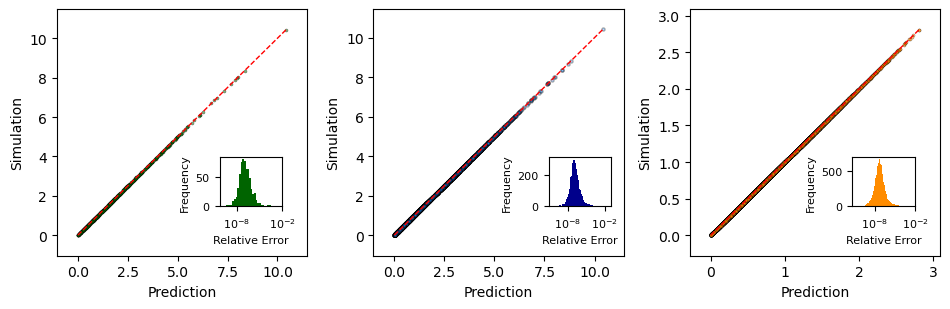

In [14]:
 from sklearn.metrics import confusion_matrix, r2_score, ConfusionMatrixDisplay
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
# Function to format ticks as 10^(log(error))
def log_formatter(x, pos):
    return f'$10^{{{int(x)}}}$'


def plot_confusion_matrix(true_labels, predicted_labels, labels=('Ext', 'Sur'), font_size=7, ax=None):
    cm = confusion_matrix(true_labels, predicted_labels, labels = [False,True])
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    
    display.plot(cmap='Blues', ax=ax, colorbar=False)
    
    # Set custom tick labels
    ax.set_xticklabels(labels, fontsize=font_size)
    ax.set_yticklabels(labels, fontsize=font_size)
    
    # Remove or customize axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Customize grid appearance
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
    ax.tick_params(which="both", bottom=False, left=False)

    # Change font size of text annotations
    for text in display.text_.ravel():
        text.set_fontsize(font_size)

    if ax is None:
        plt.tight_layout()
        plt.show()


# Combine scatter plots and histograms
figure_width = 3.2
fig, ax = plt.subplots(1, 3, figsize=(figure_width * 3, figure_width * 1))

# Filter data for positive predictions
sim_Nbools_concatenated = np.concatenate(MCRM_unpacked_data['sim_Nbools'])
prediction_Nbool_concatenated = np.concatenate(MCRM_unpacked_data['prediction_Nbool'])
intersection = [a and b for a, b in zip(sim_Nbools_concatenated, prediction_Nbool_concatenated)]
positive_indices_N = np.array(intersection) > 0

# Filter data for positive predictions
sim_Rbools_concatenated = np.concatenate(MCRM_unpacked_data['sim_Rbools'])
prediction_Rbool_concatenated = np.concatenate(MCRM_unpacked_data['prediction_Rbool'])
intersection = [a and b for a, b in zip(sim_Rbools_concatenated, prediction_Rbool_concatenated)]
positive_indices_R = np.array(intersection) > 0

filtered_simulationR_after = np.concatenate(MCRM_unpacked_data['simulationR_after'])[positive_indices_R]
filtered_predictionRs = np.concatenate(MCRM_unpacked_data['info_Rprediction'])[positive_indices_R]


filtered_simulationN_after = np.concatenate(MCRM_unpacked_data['simulationN_after'])[positive_indices_N]
filtered_predictionNs = np.concatenate(MCRM_unpacked_data['info_Nprediction'])[positive_indices_N]

# Calculate R^2 values
#r2_n = r2_score(filtered_simulationN_after, filtered_predictionNs)
#r2_r = r2_score(filtered_simulationR_after, filtered_predictionRs)

# Scatter plot for N (reversed axes)
maxN = np.max(np.concatenate(MCRM_unpacked_data['predictionNs']))
scatter_n = ax[1].scatter(filtered_predictionNs, filtered_simulationN_after, s=5, alpha=0.3, c='dodgerblue', edgecolors='black')
ax[1].plot([0, maxN], [0, maxN], color='r', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Simulation')
ax[1].set_xlim(-maxN * 0.1, 1.1 * maxN)
ax[1].set_ylim(-maxN * 0.1, 1.1 * maxN)
#ax[1].set_title(f'consumer $N_i$')


# Histogram for relative error of N
ax_hist1 = ax[1].inset_axes([0.7, 0.2, 0.25, 0.2])
ax_hist1.hist(np.log10(np.abs(filtered_simulationN_after - filtered_predictionNs) / filtered_simulationN_after), bins='auto', color='darkblue', edgecolor='none')
ax_hist1.set_xlabel('Relative Error', fontsize=8)
ax_hist1.set_ylabel('Frequency', fontsize=8)
ax_hist1.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist1.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist1.set_xticks([-8, -2])  # Replace with your desired tick positions
ax_hist1.set_xticklabels(['$10^{-8}$', '$10^{-2}$'])  # Replace with your desired tick labels


# Scatter plot for R 
maxR = np.max(np.concatenate(MCRM_unpacked_data['predictionRs']))
scatter_r = ax[2].scatter(filtered_predictionRs, filtered_simulationR_after, s=5, alpha=0.5, linewidth=0.3, c='darkorange', edgecolors='black')
ax[2].plot([0, maxR], [0, maxR], color='r', linestyle='dashed', linewidth=1)
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Simulation')
ax[2].set_xlim(-maxR * 0.1, 1.1 * maxR)
ax[2].set_ylim(-maxR * 0.1, 1.1 * maxR)
#ax[2].set_title(f'resource $R_α$')


# Histogram for relative error of R
ax_hist2 = ax[2].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist2.hist(np.log10(np.abs(filtered_simulationR_after - filtered_predictionRs) / filtered_simulationR_after), bins='auto', color='darkorange', edgecolor='none')
ax_hist2.set_xlabel('Relative Error', fontsize=8)
ax_hist2.set_ylabel('Frequency', fontsize=8)
ax_hist2.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
# Set custom x-ticks
ax_hist2.set_xticks([-8, -2])  # Replace with your desired tick positions
ax_hist2.set_xticklabels(['$10^{-8}$', '$10^{-2}$'])  # Replace with your desired tick labels


simulation_invader = np.array([x[-1] for x in MCRM_unpacked_data['simulationN_after']])
prediction_invader = np.array([x[-1] for x in MCRM_unpacked_data['info_Nprediction']])


sim_invader_bool =  np.array([x[-1] for x in MCRM_unpacked_data['sim_Nbools']])
pred_invader_bool =  np.array([x[-1] for x in MCRM_unpacked_data['prediction_Nbool']])

intersection = [a and b for a, b in zip(sim_invader_bool, pred_invader_bool)]
N0_positive_indices = np.array(intersection) > 0
#print(sim_invader_bool,pred_invader_bool)

# Filter N_0 data for positive predictions
filtered_simulation_invader = simulation_invader[N0_positive_indices]
filtered_prediction_invader = prediction_invader[N0_positive_indices]
#r2_n0 = r2_score(filtered_simulation_invader, filtered_prediction_invader)


# Scatter plot for N_0 
maxN0 = np.max(filtered_prediction_invader)
scatter_n0 = ax[0].scatter(filtered_prediction_invader, filtered_simulation_invader, s=5, alpha=0.5, linewidth=0.3, c='darkgreen', edgecolors='black')
ax[0].plot([0, maxN0], [0, maxN0], color='r', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Simulation')
ax[0].set_xlim(-maxN0 * 0.1, 1.1 * maxN0)
ax[0].set_ylim(-maxN0 * 0.1, 1.1 * maxN0)
#ax[0].set_title(f'invader $N_0$')

# Histogram for relative error of N_0
ax_hist0 = ax[0].inset_axes([0.65, 0.2, 0.25, 0.2])
ax_hist0.hist(np.log10(np.abs(filtered_simulation_invader - filtered_prediction_invader) / filtered_simulation_invader), bins='auto', color='darkgreen', edgecolor='none')
ax_hist0.set_xlabel('Relative Error', fontsize=8)
ax_hist0.set_ylabel('Frequency', fontsize=8)
ax_hist0.xaxis.set_major_formatter(FuncFormatter(log_formatter))
ax_hist0.tick_params(axis='both', which='major', labelsize=8)

# Set custom x-ticks
ax_hist0.set_xticks([-8, -2])  # Replace with your desired tick positions
ax_hist0.set_xticklabels(['$10^{-8}$', '$10^{-2}$'])  # Replace with your desired tick labels

plt.tight_layout()
fig.savefig("MCRM_work_with_info.svg", format="svg")
fig.savefig("MCRM_work_with_info.pdf", format="pdf")

plt.show()

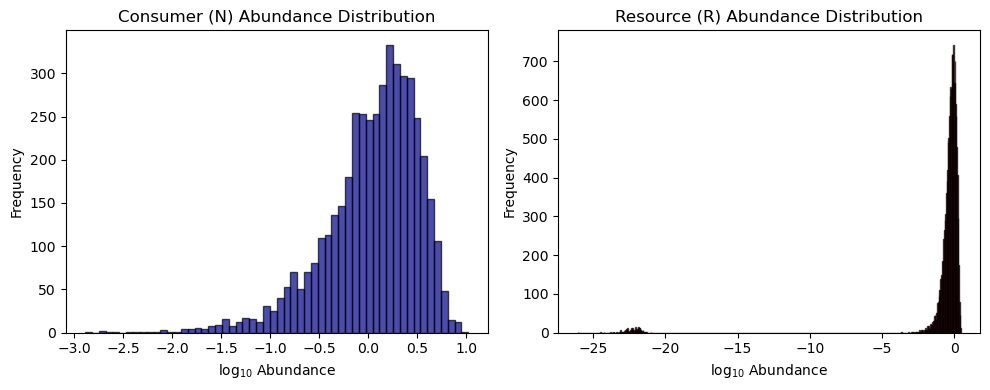

In [15]:
# Create a new figure for abundance distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


# Filter out zeros and take log10
N_abundances = np.array(np.concatenate(MCRM_unpacked_data['simulationN_after']))
R_abundances = np.array(np.concatenate(MCRM_unpacked_data['simulationR_after']))
N_abundances = N_abundances[N_abundances > 0]
R_abundances = R_abundances[R_abundances > 0]
log_N = np.log10(N_abundances)
log_R = np.log10(R_abundances)

# Plot histograms
ax1.hist(log_N, bins='auto', color='darkblue', alpha=0.7, edgecolor='black')
ax1.set_xlabel('log$_{10}$ Abundance')
ax1.set_ylabel('Frequency')
ax1.set_title('Consumer (N) Abundance Distribution')

ax2.hist(log_R, bins='auto', color='darkred', alpha=0.7, edgecolor='black')
ax2.set_xlabel('log$_{10}$ Abundance')
ax2.set_ylabel('Frequency')
ax2.set_title('Resource (R) Abundance Distribution')

plt.tight_layout()
plt.show()


In [16]:
def shift_invader_impacts(unpacked_data):
    # Extract data from unpacked_data
    invader_abundance = [arr[-1] for arr in unpacked_data['simulationN_after']]
    
    simulationN_before = unpacked_data['simulationN_before']
    simulationN_after = unpacked_data['simulationN_after']
    sim_Nbools = unpacked_data['sim_Nbools']
    sim_Rbools = unpacked_data['sim_Rbools']
    simulationR_before = unpacked_data['simulationR_before']
    simulationR_after = unpacked_data['simulationR_after']
    #naive_invasion_fitness = unpacked_data['naive_invasion_fitness']
    screened_invader_impact_N = unpacked_data['screened_invader_impact_N']
    screened_invader_impact_R = unpacked_data['screened_invader_impact_R']

    # Calculate N_shifts
    N_shifts = []
    for i in range(len(simulationN_before)):
        N_sur_before = simulationN_before[i][sim_Nbools[i][:-1]]
        N_sur_after = simulationN_after[i][sim_Nbools[i]][:-1]
        N_shifts.append(N_sur_after - N_sur_before)
    
    # Calculate R_shifts
    R_shifts = []
    for i in range(len(simulationR_before)):
        R_sur_before = simulationR_before[i][sim_Rbools[i]]
        R_sur_after = simulationR_after[i][sim_Rbools[i]]
        R_shifts.append(R_sur_after - R_sur_before)
    
    # Calculate weighted_invader_impact_N
    weighted_invader_impact_N = []
    for scalar, vector in zip(invader_abundance, screened_invader_impact_N):
        weighted_invader_impact_N.append(scalar * vector)
    
    # Calculate weighted_invader_impact_R
    weighted_invader_impact_R = []
    for scalar, vector in zip(invader_abundance, screened_invader_impact_R):
        weighted_invader_impact_R.append(scalar * vector)
    
    return N_shifts, R_shifts, weighted_invader_impact_N, weighted_invader_impact_R

def generate_sample_indices(data_length, fraction):
    """
    Generates random sample indices for downsampling.

    Parameters:
    - data_length: int, the length of the dataset.
    - fraction: float, the fraction of data to retain (between 0 and 1).

    Returns:
    - indices: list, randomly selected indices for downsampling.
    """
    if not (0 < fraction <= 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    num_samples = int(data_length * fraction)
    return np.random.choice(data_length, num_samples, replace=False)

def downsample_data(unpacked_data, fraction):
    """
    Downsamples the given dataset by a specified fraction using consistent indices.

    Parameters:
    - unpacked_data: dict, containing arrays to be downsampled.
    - fraction: float, the fraction of data to retain (between 0 and 1).

    Returns:
    - downsampled_data: dict, containing the downsampled arrays.
    """
    # Assume all datasets have the same length; use the first key to determine this
    first_key = next(iter(unpacked_data))
    data_length = len(unpacked_data[first_key])
    
    # Generate sample indices once
    sample_indices = generate_sample_indices(data_length, fraction)
    
    downsampled_data = {}
    
    for key, data in unpacked_data.items():
        # Convert data to a numpy array if it isn't one already
        data_array = np.array(data, dtype=object) if not isinstance(data, np.ndarray) else data
        
        # Use the same sample indices for consistency
        downsampled_data[key] = data_array[sample_indices]
    
    return downsampled_data


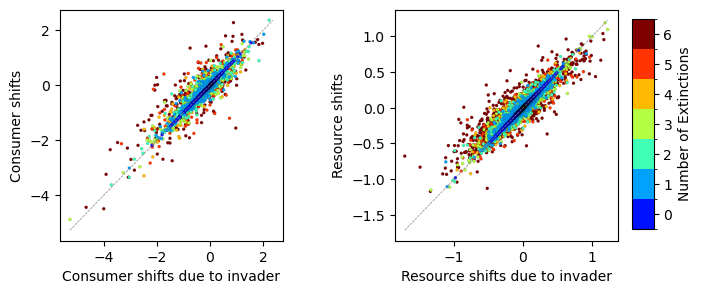

In [20]:
downsampled_data = downsample_data(MCRM_unpacked_data, 1)
N_shifts, R_shifts, weighted_invader_impact_N, weighted_invader_impact_R=shift_invader_impacts(downsampled_data)


figure_width = 3
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2.4, figure_width))

num_ext_list = []
for sim_Nbool, sim_Rbool in zip(downsampled_data['sim_Nbools'], downsampled_data['sim_Rbools']):
    Nextbool = np.logical_not(sim_Nbool)
    Rextbool = np.logical_not(sim_Rbool)
    num_ext_list.append(sum(Nextbool) + sum(Rextbool))

# Extend the color to the same length of shifts
Nextended_num_ext_list = []
for i in range(len(num_ext_list)):
    Nextended_num_ext_list += [num_ext_list[i]] * len(N_shifts[i])

Rextended_num_ext_list = []
for i in range(len(num_ext_list)):
    Rextended_num_ext_list += [num_ext_list[i]] * len(R_shifts[i])

# Flatten arrays for sorting
x1 = -np.concatenate(weighted_invader_impact_N)
y1 = np.concatenate(N_shifts)

x2 = -np.concatenate(weighted_invader_impact_R)
y2 = np.concatenate(R_shifts)

# Create structured arrays for sorting
N_data = np.array(list(zip(Nextended_num_ext_list, x1, y1)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])
R_data = np.array(list(zip(Rextended_num_ext_list, x2, y2)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_N_data = np.sort(N_data, order='extinctions')[::-1]
sorted_R_data = np.sort(R_data, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_Nextinctions = sorted_N_data['extinctions']
sorted_x1 = sorted_N_data['x']
sorted_y1 = sorted_N_data['y']

sorted_Rextinctions = sorted_R_data['extinctions']
sorted_x2 = sorted_R_data['x']
sorted_y2 = sorted_R_data['y']

# Define boundaries and colormap
boundaries = np.arange(-1.5, 7.5)
norm = BoundaryNorm(boundaries, ncolors=256)

# Create the scatter plot with discrete colors for the first plot
scatter1 = ax[0].scatter(sorted_x1, sorted_y1,
                         s=5,
                         c=sorted_Nextinctions,
                         cmap='jet',
                         alpha=1,
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.07)

ax[0].set_ylabel('Consumer shifts')
ax[0].set_xlabel('Consumer shifts due to invader')

# Add dashed line where x=y for the first plot
max_limit_1 = max(sorted_x1.max(), sorted_y1.max())
min_limit_1 = min(sorted_x1.min(), sorted_y1.min())
ax[0].plot([min_limit_1, max_limit_1], [min_limit_1, max_limit_1], color='gray', linestyle='dashed', linewidth=0.5)

# Add a separate axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
cbar = fig.colorbar(scatter1, cax=cbar_ax, boundaries=boundaries,
                    ticks=np.arange(np.min(sorted_Nextinctions), np.max(sorted_Nextinctions) + 1))
cbar.set_label('Number of Extinctions')
cbar.ax.set_ylim(np.min(sorted_num_ext_list_1)-0.5, np.max(boundaries) )

# Create the scatter plot with discrete colors for the second plot
scatter2 = ax[1].scatter(sorted_x2, sorted_y2,
                         s=5,
                         alpha=1,
                         c=sorted_Rextinctions,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.07)

ax[1].set_ylabel('Resource shifts')
ax[1].set_xlabel('Resource shifts due to invader')

# Add dashed line where x=y for the second plot
max_limit_2 = max(sorted_x2.max(), sorted_y2.max())
min_limit_2 = min(sorted_x2.min(), sorted_y2.min())
ax[1].plot([min_limit_2, max_limit_2], [min_limit_2, max_limit_2], color='gray', linestyle='dashed', linewidth=0.5)

plt.subplots_adjust(wspace=0.5)
plt.savefig('MCRM shifts.pdf', bbox_inches='tight')
plt.show()

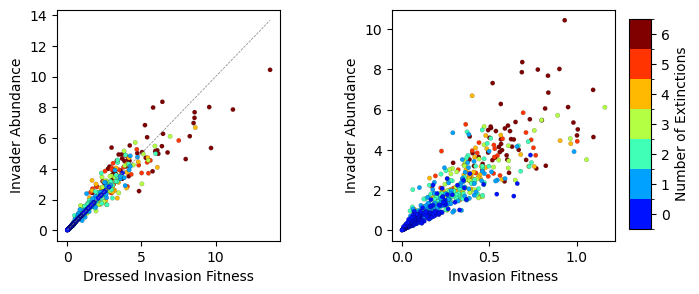

In [21]:
downsampled_data = downsample_data(MCRM_unpacked_data, 1)

# Calculate the number of extinctions
num_ext_list = []
for sim_Nbool, sim_Rbool in zip(downsampled_data['sim_Nbools'], downsampled_data['sim_Rbools']):
    Nextbool = np.logical_not(sim_Nbool)
    Rextbool = np.logical_not(sim_Rbool)
    num_ext_list.append(sum(Nextbool) + sum(Rextbool))

figure_width = 3
fig, ax = plt.subplots(1, 2, figsize=(figure_width * 2.4, figure_width))

# Define boundaries and colormap
boundaries = np.arange(-1.5, 7.5)
norm = BoundaryNorm(boundaries, ncolors=256)

invader_abundance = np.array([arr[-1] for arr in downsampled_data['simulationN_after']])

# Data for the first plot
x1 = np.multiply(np.concatenate(downsampled_data['invasion_fitness']),
                      np.concatenate(np.concatenate(downsampled_data['Minv'])))
y1 = invader_abundance

# Create a structured array for sorting
data1 = np.array(list(zip(num_ext_list, x1, y1)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_data1 = np.sort(data1, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_1 = sorted_data1['extinctions']
sorted_x1 = sorted_data1['x']
sorted_y1 = sorted_data1['y']

# Create the scatter plot with discrete colors for the first plot
scatter1 = ax[0].scatter(sorted_x1, sorted_y1,
                         s=10,
                         c=sorted_num_ext_list_1,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

# Add dashed line where x=y for the first plot
max_limit_1 = max(sorted_x1.max(), sorted_y1.max())
min_limit_1 = min(sorted_x1.min(), sorted_y1.min())
ax[0].plot([min_limit_1, max_limit_1], [min_limit_1, max_limit_1], color='gray', linestyle='dashed', linewidth=0.5)

ax[0].set_ylabel('Invader Abundance')
ax[0].set_xlabel('Dressed Invasion Fitness')
#ax[0].set_xlim(-10, 450)

# Add a separate axis for the colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
cbar = fig.colorbar(scatter1, cax=cbar_ax, boundaries=boundaries,
                    ticks=np.arange(np.min(sorted_num_ext_list_1), np.max(sorted_num_ext_list_1) + 1))
cbar.set_label('Number of Extinctions')
cbar.ax.set_ylim(np.min(sorted_num_ext_list_1)-0.5, np.max(boundaries) )

# Data for the second plot
x2 = np.concatenate(downsampled_data['invasion_fitness'])
y2 = invader_abundance

# Create a structured array for sorting
data2 = np.array(list(zip(num_ext_list, x2, y2)), dtype=[('extinctions', 'i4'), ('x', 'f4'), ('y', 'f4')])

# Sort data by number of extinctions in descending order
sorted_data2 = np.sort(data2, order='extinctions')[::-1]

# Extract sorted values for plotting
sorted_num_ext_list_2 = sorted_data2['extinctions']
sorted_x2 = sorted_data2['x']
sorted_y2 = sorted_data2['y']

# Create the scatter plot with discrete colors for the second plot
scatter2 = ax[1].scatter(sorted_x2, sorted_y2,
                         s=10,
                         alpha=1,
                         c=sorted_num_ext_list_2,
                         cmap='jet',
                         norm=norm,
                         edgecolors='black',
                         linewidth=0.1)

ax[1].set_ylabel('Invader Abundance')
ax[1].set_xlabel('Invasion Fitness')

plt.subplots_adjust(wspace=0.5)
plt.savefig('MCRM dressed invasion fitness.pdf', bbox_inches='tight')
plt.show()